In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pseudo_arclength import *  # Local file, for multiple solutions

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from Models import *
from Models.FENE import *

In [4]:
ndim = 3  # Spatial dimensions

## Steady Shear

In [5]:
Wimax = 1e3  # Maximum Weissenberg number

In [6]:
def shear_flow(Wimax, constEq, con_kwargs={}, pal_kwargs={}):
    """Shear flow for different constitutive models.

    Parameters
    ----------
    Wimax : float
        Maximal Wi-value.
    constEq : ConstitutiveModel
        Static class for constitutive model.
    con_kwargs : dict
        Parameters for constitutive model.
    pal_kwargs : dict
        Parameters for pseudo-arclength continuation.

    Returns
    -------
    Wi : narray
        Array of Weissenberg numbers.
    τ : narray
        Array of (polymeric and viscous) stress tensors.
    """
    # Gradient for different shear flows (non-dimensional)
    gradU = np.array([[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0]])
    # Residual + residual for arclength
    residual = lambda A, Wi: constEq.equation(A, gradU, Wi, **con_kwargs)
    adj_residual = lambda T: residual(T[:-1].reshape(constEq.zero_state(ndim).shape), T[-1]).flatten()
    # Run pseudo-arclength continuation
    T0 = np.hstack([constEq.zero_state(ndim).flatten(), 0.01])
    T = pseudo_arclength(adj_residual, T0, Wimax, **pal_kwargs)
    # Transform output
    nSteps = len(T)
    τ = np.empty((nSteps, ndim, ndim))
    Wi = np.empty((nSteps))
    for idx in range(nSteps):
        A = T[idx][:-1].reshape(constEq.zero_state(ndim).shape)
        Wi[idx] = T[idx][-1]
        τ[idx] = Wi[idx]*constEq.stress_tensor(A, gradU, Wi[idx], **con_kwargs)
    return Wi, τ

In [7]:
models = [
    Oldroyd_B.Oldroyd_B,
    Oldroyd_A.Oldroyd_A,
    FENE_CR.FENE_CR,
    FENE_P.FENE_P,
    Johnson_Segalman.Johnson_Segalman,
    Giesekus.Giesekus,
]
model_parameters = [
    {"β":0.5},
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "L":100},
    {"β":0.0, "ε0":0.2},
    {"β":0.0, "α":0.9},
]

In [8]:
res = []  # Result of every model requested
for idx, model in enumerate(models):
    Wi, τ = shear_flow(Wimax, model, model_parameters[idx])
    res.append((Wi, τ))

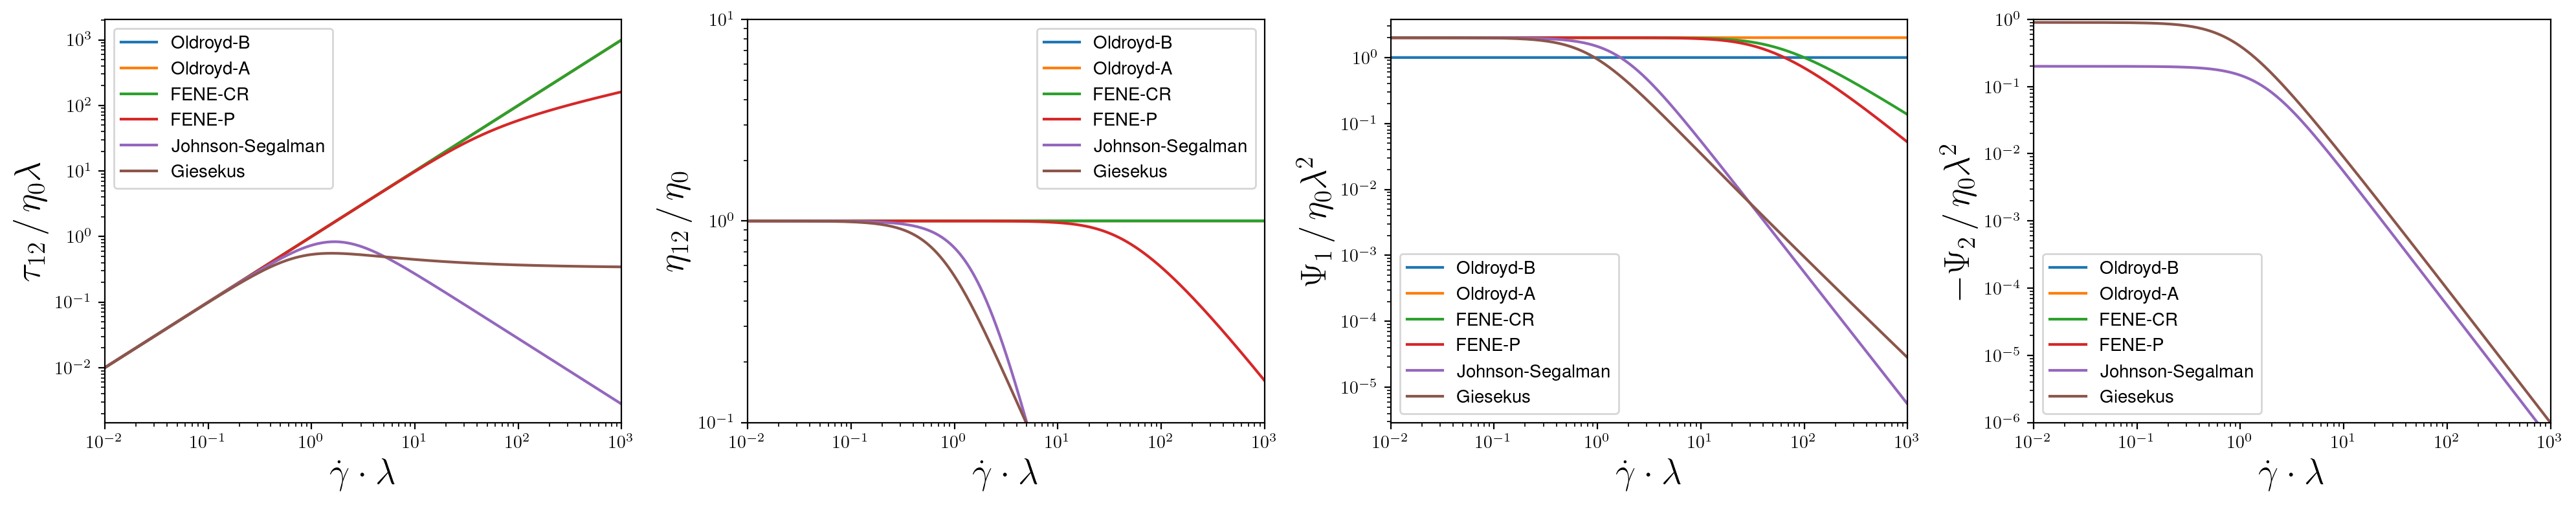

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
for idx, model in enumerate(models):
    Wi, τ = res[idx]
    axes[0].plot(Wi, τ[:,0,1], label=model.name)
    axes[1].plot(Wi, τ[:,0,1]/Wi, label=model.name)
    axes[2].plot(Wi, (τ[:,0,0]-τ[:,1,1])/Wi**2, label=model.name)
    axes[3].plot(Wi, -(τ[:,1,1]-τ[:,2,2])/Wi**2, label=model.name)

axes[0].set_ylabel("$\\tau_{12} \\,/\\, \\eta_0 \\lambda$", size=20)
axes[1].set_ylabel("$\\eta_{12} \\,/\\, \\eta_0$", size=20)
axes[2].set_ylabel("$\\Psi_1 \\,/\\, \\eta_0 \\lambda^2$", size=20)
axes[3].set_ylabel("$-\\Psi_2 \\,/\\, \\eta_0 \\lambda^2$", size=20)
for ax in axes:
    ax.set_xlabel("$\\dot{{\\gamma}} \\cdot \\lambda$", size=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-2,Wimax])
    ax.legend()
axes[1].set_ylim([1e-1,1e1])
axes[3].set_ylim([1e-6,1e0])
plt.tight_layout()
plt.show()

## Shear Startup

In [10]:
from scipy.integrate import RK45, Radau, LSODA

In [11]:
def shear_startup(Wi, constEq, con_kwargs={}, ODESolver=RK45, tmax=1e4, ttol=None):
    """Shear flow for different constitutive models.

    Parameters
    ----------
    Wi : float
        Wi-value.
    constEq : ConstitutiveModel
        Static class for constitutive model.
    con_kwargs : dict
        Parameters for constitutive model.
    ODESolver : scipy.integrate.ODESolver
        Solver for the ODE.
    tmax : float
        Maximum time value (early stopping if seemingly converged).
    ttol : float
        Tolerance before assuming steady state is reached.

    Returns
    -------
    t : narray
        Array of time steps.
    τ : narray
        Array of (polymeric and viscous) stress tensors.
    """
    # Gradient for different shear flows (non-dimensional)
    gradU = np.array([[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0]])
    # Initial values
    t0 = 0.0
    A0 = constEq.zero_state(ndim)
    # RHS
    rhs = lambda A: -constEq.equation(A, gradU, Wi, **con_kwargs)
    adj_rhs = lambda t, A: rhs(A.reshape(A0.shape)).flatten()
    # Run ODE
    sol = ODESolver(adj_rhs, t0, A0.flatten(), tmax, max_step=1)

    tvals = [t0]
    Avals = [A0]
    running = True
    while running:
        # Solve next step
        sol.step()
        tvals.append(sol.t)
        Avals.append(sol.y.reshape(A0.shape))
        # Determine end criterions:
        if  sol.status == "finished" or  sol.status == "failed":
            warnings.warn(f"Ended due to solver status={sol.status}",
                          RuntimeWarning)
            running = False
        elif ttol is not None and np.linalg.norm(Avals[-1]-Avals[-2]) < np.linalg.norm(Avals[-1])*ttol:
            running = False

    # Transform output
    nSteps = len(tvals)
    τ = np.empty((nSteps, ndim, ndim))
    t = np.array(tvals)
    for idx in range(nSteps):
        A = Avals[idx].reshape(A0.shape)
        τ[idx] = Wi*constEq.stress_tensor(A, gradU, Wi, **con_kwargs)
    return t, τ

In [12]:
Wi_startup = 30.0
models = [
    Oldroyd_B.Oldroyd_B,
    Oldroyd_A.Oldroyd_A,
    FENE_CR.FENE_CR,
    FENE_P.FENE_P,
    Johnson_Segalman.Johnson_Segalman,
    Giesekus.Giesekus,
    FENE_P_Multimode.FENE_P_Multimode(2)
]
model_parameters = [
    {"β":0.0},
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "L":100},
    {"β":0.0, "ε0":0.2},
    {"β":0.0, "α":0.9},
    {"β":[0.5, 0.5], "L": [100, 50], "λfrac": [1.0, 0.5]}
]

In [13]:
res_startup = []  # Result of every model requested
for idx, model in enumerate(models):
    t, τ = shear_startup(Wi_startup, model, model_parameters[idx], ODESolver=LSODA)
    res_startup.append((t, τ))

/var/folders/c5/lbbmdc4d2vg95yy7720wmcyh0000gp/T/ipykernel_20648/1693508596.py:49: RuntimeWarning: Ended due to solver status=finished
  warnings.warn(f"Ended due to solver status={sol.status}",


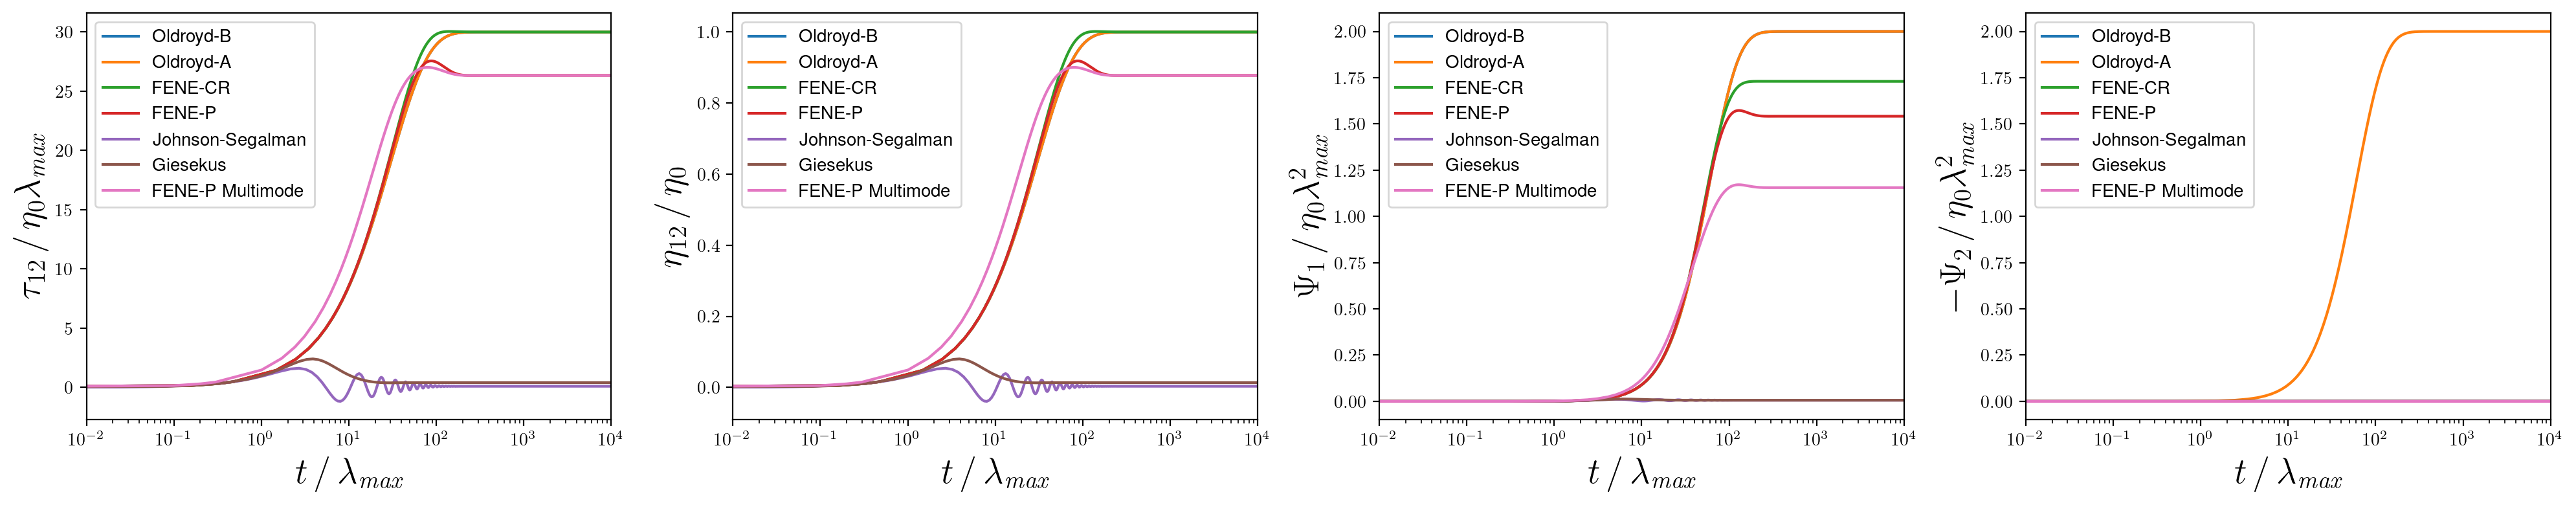

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))

for idx, model in enumerate(models):
    t, τ = res_startup[idx]
    axes[0].plot(t, τ[:,0,1], label=model.name)
    axes[1].plot(t, τ[:,0,1]/Wi_startup, label=model.name)
    axes[2].plot(t, (τ[:,0,0]-τ[:,1,1])/Wi_startup**2, label=model.name)
    axes[3].plot(t, -(τ[:,1,1]-τ[:,2,2])/Wi_startup**2, label=model.name)

axes[0].set_ylabel("$\\tau_{12} \\,/\\, \\eta_0 \\lambda_\\mathit{max}$", size=20)
axes[1].set_ylabel("$\\eta_{12} \\,/\\, \\eta_0$", size=20)
axes[2].set_ylabel("$\\Psi_1 \\,/\\, \\eta_0 \\lambda_\\mathit{max}^2$", size=20)
axes[3].set_ylabel("$-\\Psi_2 \\,/\\, \\eta_0 \\lambda_\\mathit{max}^2$", size=20)
for ax in axes:
    ax.set_xlabel("$t \\,/\\, \\lambda_\\mathit{max}$", size=20)
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlim([1e-2,1e4])
    ax.legend()
plt.tight_layout()
plt.show()

## Step Strain

In [15]:
from scipy.integrate import RK45, Radau, LSODA

In [16]:
def step_strain(γ, dt, constEq, con_kwargs={}, ODESolver=RK45, tmax=1e4, ttol=None):
    """Step strain for different constitutive models.

    Parameters
    ----------
    γ : float
        Step size.
    dt : float
        Size of step using Gaussian.
    constEq : ConstitutiveModel
        Static class for constitutive model.
    con_kwargs : dict
        Parameters for constitutive model.
    ODESolver : scipy.integrate.ODESolver
        Solver for the ODE.
    tmax : float
        Maximum time value (early stopping if seemingly converged).
    ttol : float
        Tolerance before assuming steady state is reached.

    Returns
    -------
    t : narray
        Array of time steps.
    τ : narray
        Array of (polymeric and viscous) stress tensors.
    """
    # Gradient for different shear flows (non-dimensional)
    gradU = lambda t: np.array([[0.0, 0.0, 0.0],
                                [γ/np.sqrt(np.pi*dt**2/9)*np.exp(-(t-dt/2)**2/(dt**2/9)), 0.0, 0.0],
                                [0.0, 0.0, 0.0]])
    # Initial values
    t0 = 0.0
    A0 = constEq.zero_state(ndim)
    # RHS
    rhs = lambda A, t: -constEq.equation(A, gradU(t), 1, **con_kwargs)
    adj_rhs = lambda t, A: rhs(A.reshape(A0.shape), t).flatten()
    # Run ODE
    sol = ODESolver(adj_rhs, t0, A0.flatten(), tmax, max_step=1)

    tvals = [t0]
    Avals = [A0]
    running = True
    while running:
        # Solve next step
        sol.step()
        tvals.append(sol.t)
        Avals.append(sol.y.reshape(A0.shape))
        # Determine end criterions:
        if  sol.status == "finished" or  sol.status == "failed":
            warnings.warn(f"Ended due to solver status={sol.status}",
                          RuntimeWarning)
            running = False
        elif ttol is not None and np.linalg.norm(Avals[-1]-Avals[-2]) < np.linalg.norm(Avals[-1])*ttol:
            running = False

    # Transform output
    nSteps = len(tvals)
    τ = np.empty((nSteps, ndim, ndim))
    t = np.array(tvals)
    for idx in range(nSteps):
        A = Avals[idx].reshape(A0.shape)
        τ[idx] = 1*constEq.stress_tensor(A, gradU(t[idx]), 1, **con_kwargs)
    return t, τ

In [17]:
γ, dt = 5, 0.1
models = [
    Oldroyd_B.Oldroyd_B,
    Oldroyd_A.Oldroyd_A,
    FENE_CR.FENE_CR,
    FENE_P.FENE_P,
    Johnson_Segalman.Johnson_Segalman,
    Giesekus.Giesekus,
    FENE_P_Multimode.FENE_P_Multimode(2),
    CoupledUCM.CoupledUCM,
    FENE_P_Multimode.FENE_P_Multimode(10),
]
model_parameters = [
    {"β":0.0},
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "L":100},
    {"β":0.0, "ε0":0.2},
    {"β":0.0, "α":0.9},
    {"β":[0.2, 0.8], "L": [100, 50], "λfrac": [1.0, 0.5]},
    {"λ":2.0, "β1":0.2, "θ":0.1},
    {"β":[2**-n for n in range(1,11)], "L": [1000 for n in range(1,11)], "λfrac": [0.5**-n for n in range(1,11)]},
]

In [18]:
res_stepstrain = []  # Result of every model requested
for idx, model in enumerate(models):
    t, τ = step_strain(γ, dt, model, model_parameters[idx], ODESolver=LSODA)
    res_stepstrain.append((t, τ))

/var/folders/c5/lbbmdc4d2vg95yy7720wmcyh0000gp/T/ipykernel_20648/2089277217.py:51: RuntimeWarning: Ended due to solver status=finished
  warnings.warn(f"Ended due to solver status={sol.status}",


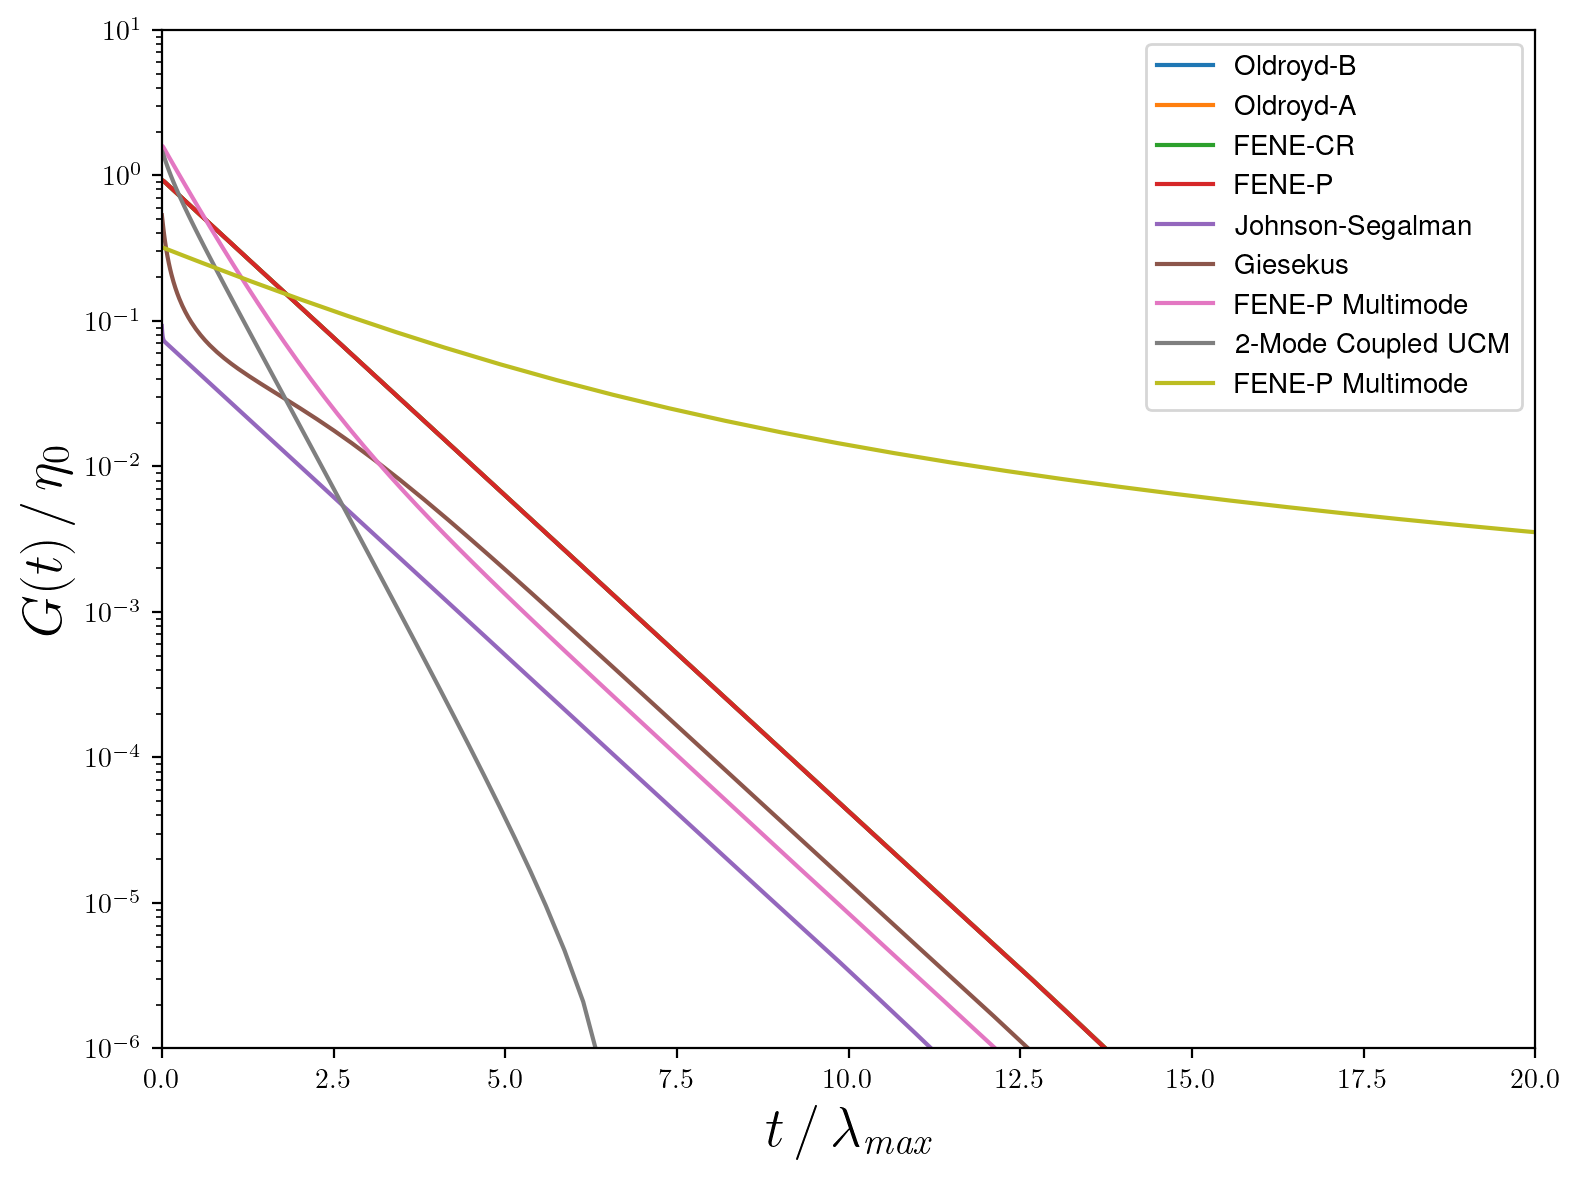

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for idx, model in enumerate(models):
    t, τ = res_stepstrain[idx]
    ax.plot(t-dt, τ[:,0,1]/γ, label=model.name)

ax.set_ylabel("$G(t) \\,/\\, \\eta_0$", size=20)
ax.set_xlabel("$t \\,/\\, \\lambda_\\mathit{max}$", size=20)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0, 20])
ax.set_ylim([1e-6, 10])
ax.legend()
plt.tight_layout()
plt.show()